<a href="https://colab.research.google.com/github/maxburton/lvl4-ml-coursework/blob/classification/CM_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer, LabelBinarizer, StandardScaler, MinMaxScaler

from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, mutual_info_classif
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import Pipeline

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/My\ Drive/Colab\ Notebooks/ML/X_train.csv .
!cp drive/My\ Drive/Colab\ Notebooks/ML/y_train.csv .
!cp drive/My\ Drive/Colab\ Notebooks/ML/X_test.csv .

In [0]:
X_test = pd.read_csv("X_test.csv")
X_train = pd.read_csv("X_train.csv")

# Subtract 1 to normalize labels to 0,1
y_train = pd.read_csv("y_train.csv")["EpiOrStroma"] - 1

# Remove columns 17 and 85, as they are (nearly) constant
drops = [X_train.columns[85], X_train.columns[17]]

X_test = X_test.drop(drops, axis=1)
X_train = X_train.drop(drops, axis=1)

In [5]:
X_test.shape

(798, 110)

## Helpers

In [0]:
def grid_search(model, parameters, X_train, y_train, cv=10):
    gs = GridSearchCV(model, parameters, cv=cv, iid=False, scoring="f1")
    gs.fit(X_train, y_train)

    result = pd.DataFrame(gs.cv_results_).sort_values(by=["mean_test_score"], ascending=False)

    params = result.params.reset_index().head(1).to_dict()["params"][0]
    return params, gs.best_estimator_


def save_output(model, X_test):
    y_pred = model.predict(X_test)
    submission = pd.DataFrame({'Id': pd.read_csv("X_test.csv").index, 'EpiOrStroma': y_pred + 1})
    submission.to_csv('submission.csv', index=False)


def plot_roc(y_true, y_pred, ax=plt):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr)
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    return roc_auc_score(y_true, y_pred)


def cv_eval(model_, X, y, n_splits=10):
    X = X.to_numpy()
    y = y.to_numpy()
    fig, ax = plt.subplots(1, figsize=(4, 4))

    acc = []
    f1 = []
    auc = []
    cv = StratifiedKFold(n_splits=n_splits)
    for train_index, test_index in cv.split(X, y):
        model = clone(model_)
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        acc.append(accuracy_score(y_te, y_pred))
        f1.append(f1_score(y_te, y_pred))
        auc.append(roc_auc_score(y_te, y_pred))
    plot_roc(y, model.predict_proba(X)[:,1], ax=ax)

    def mean(l):
        return sum(l)/len(l)

    print(f"Acc: {mean(acc)},\nF1: {mean(f1)},\nAUC: {mean(auc)}\n")

## Models

### Just classifier

Params: {'clas__algorithm': 'brute', 'clas__n_neighbors': 9}

Acc: 0.5257661038148843,
F1: 0.6174754565590146,
AUC: 0.5043542845333127



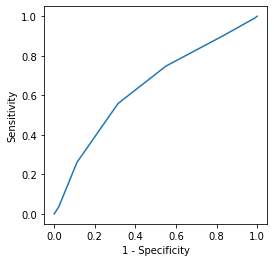

In [7]:
k = 5

model = Pipeline([
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With scaling and normalization

Params: {'clas__algorithm': 'brute', 'clas__n_neighbors': 11}

Acc: 0.8196028767979989,
F1: 0.8289708415123004,
AUC: 0.8200728512748974



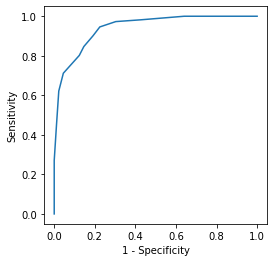

In [8]:
k = 5

model = Pipeline([
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With feature selection

Params: {'clas__algorithm': 'kd_tree', 'clas__n_neighbors': 3, 'selector__k': 20, 'selector__score_func': <function f_classif at 0x7f66f6a7f8c8>}

Acc: 0.8398530331457161,
F1: 0.845319275389255,
AUC: 0.8400772430184196



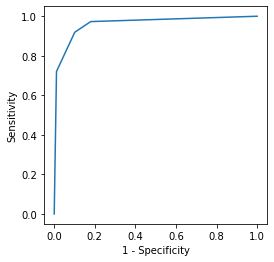

In [9]:
k = 5

model = Pipeline([
    ("selector", SelectKBest(k=10)),
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
    "selector__k": range(10, 30),
    "selector__score_func": [f_classif],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With PCA instead of k best



Params: {'clas__algorithm': 'brute', 'clas__n_neighbors': 7, 'selector__n_components': 8}

Acc: 0.7946998123827391,
F1: 0.8218612505203303,
AUC: 0.787213567904105



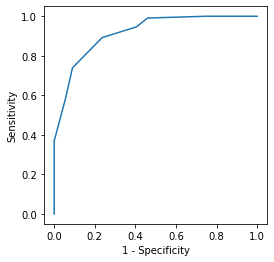

In [10]:
k = 5

model = Pipeline([
    ("selector", PCA()),
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
    "selector__n_components": range(2, 20),
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### Final

Params: {'clas__algorithm': 'brute', 'clas__n_neighbors': 5}

Acc: 0.8402130325814536,
F1: 0.851270111530981,
AUC: 0.8383838383838385

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        89
           1       0.89      0.92      0.90       111

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



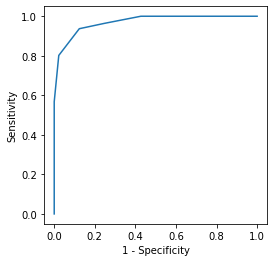

In [29]:
k = 10

model = Pipeline([
    ("scal", StandardScaler()),
    # ("scal", MinMaxScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20, score_func=f_classif)),
    ("pca", PCA(n_components=3)),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

final = clone(best)
final.fit(X_train, y_train)

save_output(final, X_test)

In [13]:
mask = best["selector"].get_support()
selected = X_train.columns[mask]
for col in selected:
    print(col)

Mean.Layer.1
Mean.Layer.3
Skewness.Layer.1
Ratio.Layer.3
Mean.of.inner.border.Layer.1
Mean.of.inner.border.Layer.3
Contrast.to.neighbor.pixels.Layer.1..3.
Circular.Mean.Layer.1..R1..User..3..R2..Same...R1...border.
Mean.diff..to.scene.Layer.1
Ratio.to.scene.Layer.1
HSI.Transformation.Hue.R.Layer.1.G.Layer.2.B.Layer.3.
Asymmetry.of.sub.objects..mean..1.
GLCM.Homogeneity..quick.8.11..Layer.1..all.dir..
GLCM.Entropy..quick.8.11..Layer.1..all.dir..
GLCM.Mean..quick.8.11..Layer.1..all.dir..
Number.of.sub.objects.Nucleus..1.
Area.of.sub.objects.Nucleus..1...Pxl.
Rel..area.of.sub.objects.Nucleus..1.
Rel..area.of.sub.objects.Dark..1.
Rel..area.of.sub.objects.unclassified..1.


## (Additional test: Oversampling)

Params: {'clas__algorithm': 'ball_tree', 'clas__n_neighbors': 5}

Acc: 0.8344486215538847,
F1: 0.8360945298027678,
AUC: 0.836868686868687



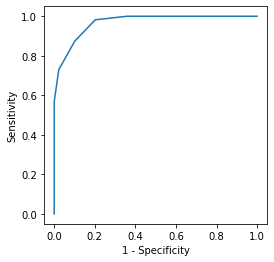

In [27]:
k = 10

model = Pipeline([
    ("resample", SMOTE()),
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20, score_func=f_classif)),
    ("pca", PCA(n_components=3)),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

final = clone(best)
final.fit(X_train, y_train)
save_output(final, X_test)

## (Additional test: MinMax scaling)

Params: {'clas__algorithm': 'brute', 'clas__n_neighbors': 12}

Acc: 0.8497117794486215,
F1: 0.8543785830537749,
AUC: 0.850189393939394



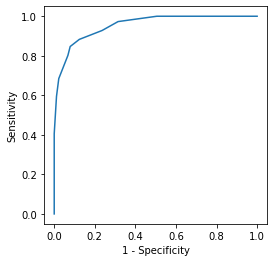

In [26]:
k = 10

model = Pipeline([
    # ("scal", StandardScaler()),
    ("scal", MinMaxScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20, score_func=chi2)),
    ("pca", PCA(n_components=3)),
    ("clas", KNeighborsClassifier()),
])

parameters = {
    "clas__n_neighbors": range(2, 13),
    "clas__algorithm": ["ball_tree", "kd_tree", "brute"],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

final = clone(best)
final.fit(X_train, y_train)
save_output(final, X_test)

## (Additional test: Voting classifier)

Acc: 0.8397117794486215,
F1: 0.8362924901185771,
AUC: 0.8404040404040405



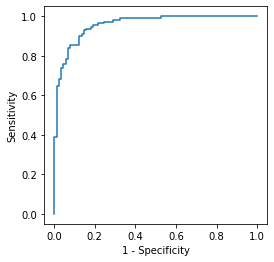

In [21]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

k = 10

model = Pipeline([
    ("scal", StandardScaler()),
    ("selector", SelectKBest(k=20)),
    ("pca", PCA(n_components=3)),
    ("clas", VotingClassifier(
        estimators=[
            # ('knn', KNeighborsClassifier()), 
            ('svc', SVC(probability=True, gamma="auto")),
            ("log", LogisticRegression(solver="saga", penalty="l1")),
        ], 
    voting='soft'))
])

cv_eval(model, X_train, y_train, n_splits=k)

final = clone(model)
final.fit(X_train, y_train)
save_output(final, X_test)